![](https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png)

# <b>Introduction<b>

Conformance checking is a techniques to compare a process model with an event log of the same process. The goal is to check if the event log conforms to the model, and, vice versa.

In pm4py, two fundamental techniques are implemented: token-based replay and alignments.

# <b>1. Setup</b>

## <b>1.1. Packages</b>

In [1]:
# python ######################################################################
import sys
import os
import datetime

# basics ######################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# widgets #####################################################################
import ipywidgets as widgets
from ipywidgets import interact

# process mining ##############################################################
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner


# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay


# algo.evaluation
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator


# vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer


# util
from pm4py.util import vis_utils


# Define directories
from src import SRC_DIR

import warnings
warnings.filterwarnings("ignore")

<br><br>
## <b>1.2. Setting</b>

In [2]:
pd.set_option('display.max_rows', 50)

In [3]:
sns.set_theme()

<br><br>
## <b>1.3. Import Event Log</b>

In [4]:
log = xes_importer.apply(os.path.join('log', SRC_DIR / 'Datasets' / 'Example' / 'Running_Example' / 'running-example.xes'))

log_csv = pd.read_csv(SRC_DIR / 'Datasets' / 'Example' / 'Running_Example' / 'running-example.csv', sep=';')
pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

log_csv.head()

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

,case_id,activity,timestamp,costs,resource,case:concept:name,concept:name,time:timestamp
0,3,register request,2010-12-30 13:32:00+00:00,50,Pete,3,register request,2010-12-30 13:32:00+00:00
1,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike,3,examine casually,2010-12-30 14:06:00+00:00
2,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen,3,check ticket,2010-12-30 15:34:00+00:00
3,3,decide,2011-01-06 08:18:00+00:00,200,Sara,3,decide,2011-01-06 08:18:00+00:00
4,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara,3,reinitiate request,2011-01-06 11:18:00+00:00


<br></br>
# <b>2. Conformance checking</b>

## <b>2.1 Token-based replay</b>

Token-based replay matches a trace and a Petri net model, starting from the initial place, in order to discover which transitions are executed and in which places we have remaining or missing tokens for the given process instance.

The output of the token-based replay contains for each trace of the log:
* <b>trace_is_fit</b>: boolean value (True/False) that is true when the trace is according to the model.
* <b>activated_transitions</b>: list of transitions activated in the model by the token-based replay.
* <b>reached_marking</b>: marking reached at the end of the replay.
* <b>missing_tokens</b>: number of missing tokens.
* <b>consumed_tokens</b>: number of consumed tokens.
* <b>remaining_tokens</b>: number of remaining tokens.
* <b>produced_tokens</b>: number of produced tokens.

For each trace, there are four values which have to be determined: <b>P</b>roduced tokens, <b>R</b>emaining tokens, <b>M</b>issing tokens, and <b>C</b>onsumed tokens. Based on that, a fomrula can be dervied, whereby a petri net (</b>n</b>) and a trace (<b>t</b>) are given as input:

fitness(n, t) = 1⁄2 (1 - r ⁄ p) + 1⁄2 (1 - m ⁄ c)

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

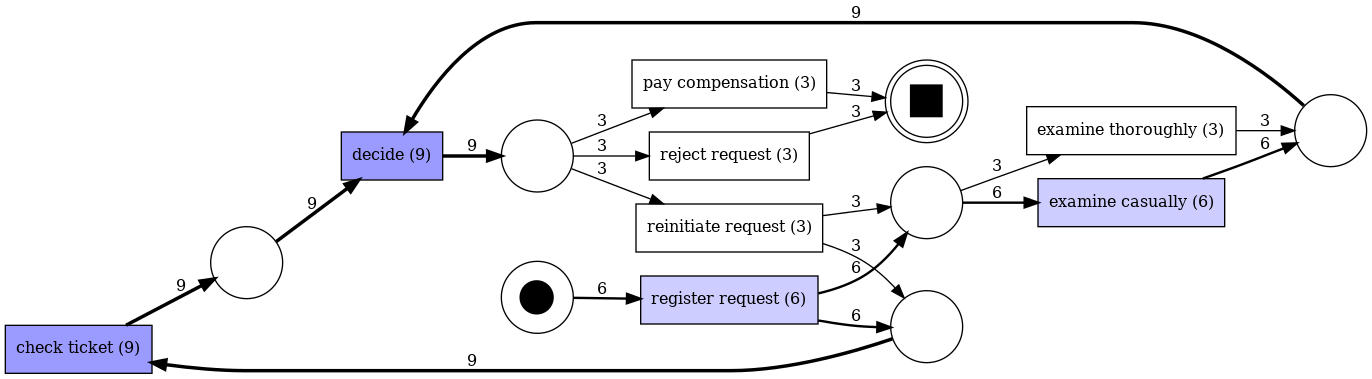

In [6]:
# Miner
petri_net, initial_marking, final_marking = alpha_miner.apply(log)

# GraphViz
gviz = pn_visualizer.apply(petri_net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# View
pn_visualizer.view(gviz)

In [8]:
# Token Replay
replayed_traces = token_replay.apply(log, petri_net, initial_marking, final_marking)

# Replayed Traces
df_replayed_traces = pd.DataFrame(replayed_traces)
df_replayed_traces.head(50)

# df_replayed_traces.iloc[2, [0, 1, 2, 6, 7, 8, 9]].activated_transitions

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

,trace_is_fit,trace_fitness,activated_transitions,reached_marking,enabled_transitions_in_marking,transitions_with_problems,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,7,0,7
1,True,1.0,"[(register request, 'register request'), (chec...",{end: 1},{},[],0,7,0,7
2,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,12,0,12
3,True,1.0,"[(register request, 'register request'), (chec...",{end: 1},{},[],0,7,0,7
4,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,17,0,17
5,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,7,0,7


<br></br>
### <b>2.1.1. Token-based parameters<b>
    
The token-based replay supports different parameters:

Parameter |	Meaning
----- | -----
**Parameters.CONSIDER_REMAINING_IN_FITNESS** | If the parameter is set to **True** (as default) trace is considered fit if it does not lead to any missing/remaining token in the model.
**Parameters.TRY_TO_REACH_FINAL_MARKING_THROUGH_HIDDEN** | When the replay of the trace is completed, try to reach the final marking through invisible transitions (default: **True**)
**Parameters.STOP_IMMEDIATELY_UNFIT** | Stops the replay immediately when a missing token needs to be inserted (default: **False**)
**Parameters.WALK_THROUGH_HIDDEN_TRANS** | Enables, in general, the traversal of invisible transitions (default: **True**)
**Parameters.CLEANING_TOKEN_FLOOD** | Limits the token flooding problem by an apposite algorithm (default: **False**)
**Parameters.RETURN_NAMES** | Return the transitions names, not the transition object, in the list of activated transitions for a trace.
**Parameters.ACTIVITY_KEY** | Establish the attribute of a trace to be used during the replay (default: **concept:name**), 

In [9]:
# Parameters
parameters = token_replay.Variants.TOKEN_REPLAY.value.Parameters

# Token Replay
replayed_traces = token_replay.apply(
    log, petri_net, initial_marking, final_marking,
    parameters = {
        parameters.CONSIDER_REMAINING_IN_FITNESS: False, 
        parameters.STOP_IMMEDIATELY_UNFIT: True, 
        parameters.WALK_THROUGH_HIDDEN_TRANS: False, 
        parameters.RETURN_NAMES: False,
    }
)

# Replayed Traces
pd.DataFrame(replayed_traces).head()

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

,trace_is_fit,trace_fitness,activated_transitions,reached_marking,enabled_transitions_in_marking,transitions_with_problems,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,7,0,7
1,True,1.0,"[(register request, 'register request'), (chec...",{end: 1},{},[],0,7,0,7
2,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,12,0,12
3,True,1.0,"[(register request, 'register request'), (chec...",{end: 1},{},[],0,7,0,7
4,True,1.0,"[(register request, 'register request'), (exam...",{end: 1},{},[],0,17,0,17


<br></br>
### <b>2.1.2 Example</b>

In [10]:
# Create filtered/partial log: drop activity 'decide'
filtered_log = log_csv[~log_csv['activity'].isin(['decide'])]

In [11]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(filtered_log, variant=variants.classic)

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

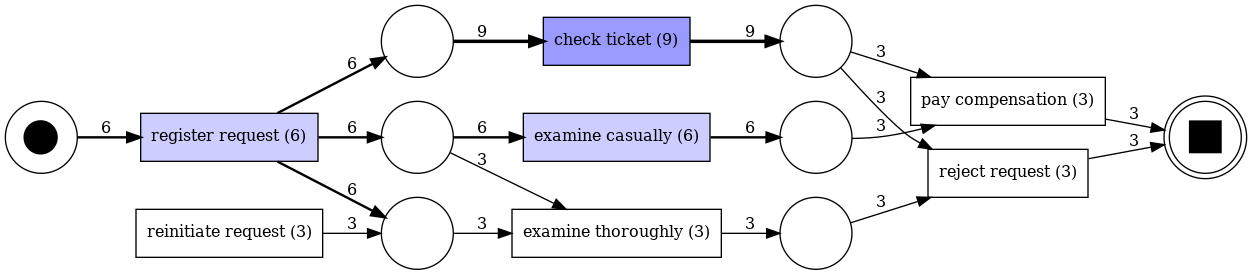

In [12]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters = parameters, 
    variant = pn_visualizer.Variants.FREQUENCY, 
    log = filtered_log
)

# View
pn_visualizer.view(gviz)

In [13]:
# Conformance checking
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

df_replayed_traces = pd.DataFrame(replayed_traces)
df_replayed_traces
# df_replayed_traces.iloc[2, [1, 2, 6, 7, 8, 9]].activated_transitions

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

,trace_is_fit,trace_fitness,activated_transitions,reached_marking,enabled_transitions_in_marking,transitions_with_problems,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.000000,"[(register request, 'register request'), (exam...",{end: 1},"{(reinitiate request, 'reinitiate request')}",[],0,7,0,7
1,False,0.928571,"[(register request, 'register request'), (chec...","{({'register request', 'reinitiate request'}, ...","{(reinitiate request, 'reinitiate request')}",[],0,6,1,7
2,False,0.738889,"[(register request, 'register request'), (exam...","{({'register request', 'reinitiate request'}, ...","{(reinitiate request, 'reinitiate request'), (...","[(examine thoroughly, 'examine thoroughly'), (...",2,9,3,10
3,True,1.000000,"[(register request, 'register request'), (chec...",{end: 1},"{(reinitiate request, 'reinitiate request')}",[],0,7,0,7
4,False,0.442308,"[(register request, 'register request'), (exam...","{({'register request', 'reinitiate request'}, ...","{(pay compensation, 'pay compensation'), (rein...","[(check ticket, 'check ticket'), (examine casu...",5,10,8,13
5,False,0.928571,"[(register request, 'register request'), (exam...","{({'register request', 'reinitiate request'}, ...","{(reinitiate request, 'reinitiate request')}",[],0,6,1,7


In [12]:
r_p = df_replayed_traces.remaining_tokens.sum() / df_replayed_traces.produced_tokens.sum()
m_c = df_replayed_traces.missing_tokens.sum() / df_replayed_traces.consumed_tokens.sum()

(1 - r_p) / 2 + (1 - m_c) / 2

0.7947712418300654

<br></br>
### <b>2.1.3. evaluation</b>

#### <b>2.1.3.1. Fitness</b>

In [13]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator

fitness = replay_fitness_evaluator.apply(filtered_log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

fitness

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 33.333333333333336,
 'average_trace_fitness': 0.8397232397232398,
 'log_fitness': 0.7947712418300654,
 'percentage_of_fitting_traces': 33.333333333333336}

<br></br>
#### <b>2.1.3.2. Precision</b>

* <i>Muñoz-Gama, Jorge, and Josep Carmona. "A fresh look at precision in process conformance." International Conference on Business Process Management. Springer, Berlin, Heidelberg, 2010.</i>

In [14]:
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator

prec = precision_evaluator.apply(filtered_log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

prec

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

0.5666666666666667

<br></br>
#### <b>2.1.3.3. Generalization</b>

* <i>Buijs, Joos CAM, Boudewijn F. van Dongen, and Wil MP van der Aalst. "Quality dimensions in process discovery: The importance of fitness, precision, generalization and simplicity." International Journal of Cooperative Information Systems 23.01 (2014): 1440001.</i>

In [14]:
gen = generalization_evaluator.apply(filtered_log, net, initial_marking, final_marking)

gen

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

0.5058241441400625

<br></br>
#### <b>2.1.3.4. Simplicity</b>

* <i>Blum, Fabian Rojas. Metrics in process discovery. Technical Report TR/DCC-2015-6, Computer Science Department, University of Chile, 2015.</i>

In [15]:
simp = simplicity_evaluator.apply(net)

simp

0.7142857142857143

<br></br>
# <b>Resources:</b>
- PM4PY [documentation](https://pm4py.fit.fraunhofer.de/documentation)
- PM4Py [documentation](http://pm4py.pads.rwth-aachen.de/documentation/) (older version)
- Towards Data Science story [Introduction to Process Mining](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5)
- Process Mining for Python on [Youtube](https://www.youtube.com/channel/UCRcgOKrDsntrTI78RXXliuw/videos)
- Wikipedia page [process mining](https://en.wikipedia.org/wiki/Process_mining)
- Wikipedia page [Petri net](https://en.wikipedia.org/wiki/Petri_net)
- Alpha Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15636)
- Heuristics Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15639)
- Inductive Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15642)
- pm4py tutorials - tutorial #8 conformance checking [video](https://www.youtube.com/watch?v=0YNvijqX3FY)
- Workflow Net and Soundness [video](https://www.coursera.org/lecture/process-mining/2-5-workflow-nets-and-soundness-tBnqo)
- Process Mining Manifestio ([pdf-document](https://www.win.tue.nl/ieeetfpm/downloads/Process%20Mining%20Manifesto.pdf))
- Data Mining [Event Logs](https://data.4tu.nl/search?q=BPI)
